In [1]:
import pandas as pd
df = pd.read_csv('fpl_playerstats_2024-25.csv')

In [2]:
print(df.head())

   id  player_cost first_name           second_name  player_form       status  \
0   1          5.4      Fábio       Ferreira Vieira          0.0  Unavailable   
1   2          6.8    Gabriel     Fernando de Jesus          0.3    Available   
2   3          6.1    Gabriel  dos Santos Magalhães          8.0    Available   
3   4          8.1        Kai               Havertz          4.0    Available   
4   5          4.0       Karl                  Hein          0.0  Unavailable   

   minutes player_position  goals_scored  assists  ...  red_cards  gw1_points  \
0        0             MID             0        0  ...          0         0.0   
1       18             FWD             0        0  ...          0         0.0   
2      450             DEF             2        0  ...          0         6.0   
3      450             FWD             2        1  ...          0        12.0   
4        0             GKP             0        0  ...          0         0.0   

   gw2_points  gw3_points 

# Player Archetype Clustering with Multimodal Embeddings

Objective: Cluster players into novel archetypes using numerical stats (e.g., goals_scored, assists, influence) and textual embeddings of player and team names, revealing hidden patterns in player roles.

Novelty: Combines numerical FPL stats with NLP-derived embeddings to uncover archetypes beyond traditional position-based groupings, offering a new lens on player similarity.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
import torch
from umap import UMAP
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load and preprocess the dataset

Note: Load the CSV file and select relevant numerical and text features.

Justification: Numerical features capture performance; text features add semantic context.

In [4]:
df = pd.read_csv('fpl_playerstats_2024-25.csv')
num_features = ['goals_scored', 'assists', 'influence', 'creativity', 'threat', 'player_cost', 'total_points']
text_feature = df['first_name'] + ' ' + df['second_name'] + ' ' + df['team_name']

# Normalize numerical features
Note: Standardize numerical features to ensure equal weighting in clustering.

Justification: Prevents features with larger scales (e.g., influence) from dominating.

In [5]:
scaler = StandardScaler()
X_num = scaler.fit_transform(df[num_features])

# Generate text embeddings using BERT

Note: Use a pre-trained BERT model to encode player and team names.

Justification: BERT captures semantic relationships, e.g., similar player roles or team styles.

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
inputs = tokenizer(text_feature.tolist(), return_tensors='pt', padding=True, truncation=True, max_length=128)
with torch.no_grad():
    embeddings = model(**inputs).last_hidden_state.mean(dim=1).numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Combine numerical and text features

Note: Concatenate normalized numerical features and text embeddings.

Justification: Multimodal features enable richer clustering.

In [7]:
X_combined = np.concatenate([X_num, embeddings], axis=1)

# Dimensionality reduction with UMAP


Note: Reduce dimensionality for clustering and visualization.

Justification: UMAP preserves local structure better than PCA for clustering tasks.

In [8]:
umap = UMAP(n_components=2, random_state=42)
X_reduced = umap.fit_transform(X_combined)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


# Cluster players using K-Means

Note: Apply K-Means to group players into archetypes (e.g., 5 clusters).

Justification: K-Means is simple and effective for discovering distinct player groups.


In [9]:
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# Visualize and analyze clusters

Note: Plot clusters and display sample players per cluster.

Justification: Visualization helps interpret archetypes; sampling provides concrete examples.

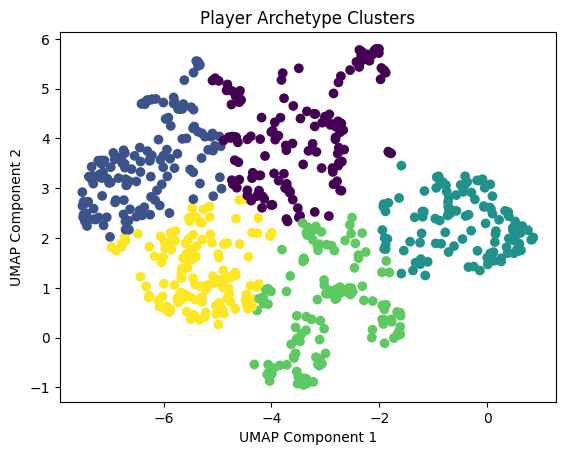

In [10]:
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=clusters, cmap='viridis')
plt.title('Player Archetype Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.show()

# Display sample players per cluster

In [11]:
df['cluster'] = clusters
for cluster in range(5):
    print(f"\nCluster {cluster}:")
    print(df[df['cluster'] == cluster][['first_name', 'second_name', 'player_position', 'total_points']].head(3))


Cluster 0:
   first_name second_name player_position  total_points
3         Kai     Havertz             FWD          26.0
9       Ethan     Nwaneri             MID           1.0
13     Bukayo        Saka             MID          35.0

Cluster 1:
   first_name second_name player_position  total_points
5     Jurriën      Timber             DEF          15.0
12     Declan        Rice             MID           4.0
16     Kieran     Tierney             DEF           0.0

Cluster 2:
  first_name           second_name player_position  total_points
0      Fábio       Ferreira Vieira             MID           0.0
1    Gabriel     Fernando de Jesus             FWD           1.0
2    Gabriel  dos Santos Magalhães             DEF          36.0

Cluster 3:
   first_name second_name player_position  total_points
4        Karl        Hein             GKP           0.0
7       Jakub      Kiwior             DEF           1.0
10     Martin    Ødegaard             MID           7.0

Cluster 4:
   first

# Dynamic Player Valuation with Reinforcement Learning

Objective: Use reinforcement learning (RL) to dynamically adjust player valuations (player_cost) based on performance trends and team context, optimizing for points per million.

Novelty: Simulates a dynamic pricing system, unlike FPL’s static pricing, to explore optimal cost adjustments.

In [12]:
!pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [1]:
!pip install gymnasium stable-baselines3 numpy pandas

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env

# Step 1: Define the RL environment
# Note: Create a custom Gym environment for player pricing.
# Justification: RL requires a state-action-reward framework; this simulates pricing decisions.

In [3]:
class FPLEnvironment(gym.Env):
    def __init__(self, df):
        super().__init__()
        self.df = df
        self.action_space = gym.spaces.Discrete(3)  # 0: Increase cost, 1: Decrease cost, 2: Keep cost
        self.observation_space = gym.spaces.Box(
            low=0, high=np.inf, shape=(3,), dtype=np.float32
        )  # player_form, total_points, team_strength
        self.current_player = 0
        self.max_steps = len(df)

    def step(self, action):
        # Adjust cost and calculate reward
        current_cost = self.df.iloc[self.current_player]['player_cost']
        if action == 0:  # Increase by 0.1
            new_cost = current_cost + 0.1
        elif action == 1:  # Decrease by 0.1 (minimum 0.1)
            new_cost = max(current_cost - 0.1, 0.1)
        else:  # Keep
            new_cost = current_cost
        # Reward: points per million (avoid division by zero)
        reward = self.df.iloc[self.current_player]['total_points'] / max(new_cost, 0.1)
        self.current_player = (self.current_player + 1) % self.max_steps
        done = self.current_player == 0
        truncated = False  # Gymnasium requires truncated flag
        return self._get_obs(), reward, done, truncated, {}

    def reset(self, seed=None):
        # Reset environment with optional seed for reproducibility
        super().reset(seed=seed)
        self.current_player = 0
        return self._get_obs(), {}

    def _get_obs(self):
        # Return observation as numpy array
        return self.df.iloc[self.current_player][['player_form', 'total_points', 'team_strength']].values.astype(np.float32)

# Step 2: Load and preprocess data
# Note: Load CSV and select relevant features for the RL state.
# Justification: Features like form and points capture performance; team strength adds context.

In [4]:
df = pd.read_csv('fpl_playerstats_2024-25.csv')
df = df.fillna(0)  # Replace NaNs with 0 for simplicity
# Ensure selected columns are numeric
df['player_form'] = pd.to_numeric(df['player_form'], errors='coerce').fillna(0)
df['total_points'] = pd.to_numeric(df['total_points'], errors='coerce').fillna(0)
df['team_strength'] = pd.to_numeric(df['team_strength'], errors='coerce').fillna(0)
df['player_cost'] = pd.to_numeric(df['player_cost'], errors='coerce').fillna(0.1)

# Step 3: Initialize and validate environment
# Note: Create and check the custom environment.
# Justification: Ensures the environment is compatible with Stable-Baselines3.

In [5]:
env = FPLEnvironment(df)
check_env(env)

# Step 4: Train PPO model
# Note: Use PPO for RL training due to its stability.
# Justification: PPO is sample-efficient and suitable for Colab’s resources.

In [6]:
model = PPO('MlpPolicy', env, verbose=1, seed=42)
model.learn(total_timesteps=10000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 661      |
|    ep_rew_mean     | 732      |
| time/              |          |
|    fps             | 239      |
|    iterations      | 1        |
|    time_elapsed    | 8        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 661         |
|    ep_rew_mean          | 732         |
| time/                   |             |
|    fps                  | 207         |
|    iterations           | 2           |
|    time_elapsed         | 19          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010213833 |
|    clip_fraction        | 0.056       |
|    clip_range           | 0.2         |
|    entropy_loss   

# Step 5: Test the pricing model
# Note: Simulate pricing adjustments for a few players.
# Justification: Demonstrates the model’s ability to adjust costs dynamically.

In [7]:
obs, _ = env.reset()
new_costs = []
player_names = []
for _ in range(10):
    action, _ = model.predict(obs)
    current_cost = df.iloc[env.current_player]['player_cost']
    if action == 0:
        new_cost = current_cost + 0.1
    elif action == 1:
        new_cost = max(current_cost - 0.1, 0.1)
    else:
        new_cost = current_cost
    new_costs.append(new_cost)
    player_names.append(f"{df.iloc[env.current_player]['first_name']} {df.iloc[env.current_player]['second_name']}")
    obs, reward, done, truncated, _ = env.step(action)
    if done:
        obs, _ = env.reset()

# Step 6: Display results
# Note: Show original and new costs for sample players.
# Justification: Allows evaluation of the model’s pricing decisions.

In [8]:
results = pd.DataFrame({
    'Player': player_names[:10],
    'Original Cost': df.iloc[:10]['player_cost'],
    'New Cost': new_costs
})
print(results)

                         Player  Original Cost  New Cost
0         Fábio Ferreira Vieira            5.4       5.5
1     Gabriel Fernando de Jesus            6.8       6.9
2  Gabriel dos Santos Magalhães            6.1       6.0
3                   Kai Havertz            8.1       8.0
4                     Karl Hein            4.0       4.0
5                Jurriën Timber            5.5       5.4
6       Jorge Luiz Frello Filho            4.9       5.0
7                  Jakub Kiwior            4.8       4.8
8      Gabriel Martinelli Silva            6.9       6.9
9                 Ethan Nwaneri            4.5       4.4


# Gameweek Difficulty Predictor with Graph Neural Networks

Objective: Use a Graph Neural Network (GNN) to predict gameweek difficulty for each player based on team and player interactions.

Novelty: Models player-team relationships as a graph, capturing complex dependencies for individualized difficulty predictions.

# Step 1: Load and preprocess data
# Note: Load CSV and select features for GNN.
# Justification: Features capture performance and team context; filling NaNs ensures robust processing.

In [12]:
df = pd.read_csv('fpl_playerstats_2024-25.csv')
df = df.fillna(0)
features = ['player_form', 'expected_goals', 'team_strength', 'total_points']
node_features = df[features].values

# Step 2: Create graph edges
# Note: Connect players from the same team to model team synergy.
# Justification: Team-based edges capture collective performance affecting difficulty.

In [13]:
edge_index = []
for team in df['team_name'].unique():
    team_players = df[df['team_name'] == team].index
    for i in team_players:
        for j in team_players:
            if i != j:
                edge_index.append([i, j])
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Step 3: Prepare graph data
# Note: Create a PyTorch Geometric Data object with node features and edges.
# Justification: GNNs require graph-structured data; total_points is a proxy for difficulty.

In [14]:
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(df['total_points'].values, dtype=torch.float)  # Proxy for difficulty
data = Data(x=x, edge_index=edge_index, y=y)

# Step 4: Define GNN model
# Note: Use a simple Graph Convolutional Network (GCN) for prediction.
# Justification: GCNs are effective for node-level tasks like difficulty prediction.

In [17]:
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(len(features), 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

# Step 5: Train GNN
# Note: Train the model to predict difficulty (approximated by total_points).
# Justification: Supervised learning with MSE loss aligns predictions with performance.

In [18]:
model = GNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.MSELoss()(out.squeeze(), data.y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 103.00628662109375
Epoch 10, Loss: 79.97238159179688
Epoch 20, Loss: 69.05656433105469
Epoch 30, Loss: 68.8751220703125
Epoch 40, Loss: 68.40443420410156
Epoch 50, Loss: 68.17864990234375
Epoch 60, Loss: 68.17106628417969
Epoch 70, Loss: 68.10784149169922
Epoch 80, Loss: 68.1017074584961
Epoch 90, Loss: 68.08328247070312


# Step 6: Predict and display results
# Note: Generate difficulty scores and show top players.
# Justification: Ranking players by predicted difficulty aids transfer decisions.

In [19]:
model.eval()
with torch.no_grad():
    difficulty_scores = model(data).squeeze().numpy()
df['difficulty_score'] = difficulty_scores
print(df[['first_name', 'second_name', 'difficulty_score']].sort_values('difficulty_score', ascending=False).head(10))

    first_name         second_name  difficulty_score
377        Ben                Doak          9.401178
376      Diogo   Teixeira da Silva          9.401178
375     Darwin       Núñez Ribeiro          9.401178
374      Bobby               Clark          9.401178
373      Conor             Bradley          9.401178
372     Stefan  Bajčetić Maquieira          9.401178
371      Trent    Alexander-Arnold          9.401178
370    Alisson       Ramses Becker          9.401178
385   Ibrahima              Konaté          9.401178
384   Caoimhin            Kelleher          9.401178


# Step 7: Visualize difficulty scores
# Note: Plot distribution of difficulty scores.
# Justification: Visualization helps identify players with high/low difficulty.

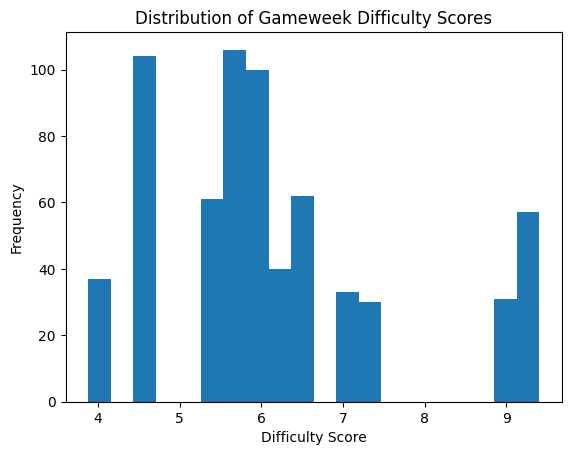

In [20]:
plt.hist(difficulty_scores, bins=20)
plt.title('Distribution of Gameweek Difficulty Scores')
plt.xlabel('Difficulty Score')
plt.ylabel('Frequency')
plt.show()

# Injury Risk Prediction with Time-Series Analysis

Objective: Predict player injury risk (based on status) using time-series analysis of gameweek data (gw1_points to gw5_points, minutes, etc.).

Novelty: Uses time-series ML to forecast injury risk, addressing a critical FPL manager concern.

In [21]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load and preprocess data
# Note: Load CSV and create time-series features.
# Justification: Time-series data (gameweek points, minutes) captures trends leading to injury.

In [22]:
df = pd.read_csv('fpl_playerstats_2024-25.csv')
df = df.fillna(0)
time_series_cols = ['gw1_points', 'gw2_points', 'gw3_points', 'gw4_points', 'gw5_points', 'minutes']
status_map = {'Available': 0, 'Injured': 1, 'Doubtful': 1, 'Suspended': 1, 'Unavailable': 1}
df['status_binary'] = df['status'].map(status_map)

# Step 2: Prepare time-series sequences
# Note: Create sequences of gameweek data for each player.
# Justification: LSTM requires sequential input; filtering complete sequences ensures data quality.

In [23]:
sequences = []
labels = []
for _, player_data in df.groupby('id'):
    sequence = player_data[time_series_cols].values
    label = player_data['status_binary'].iloc[-1]
    if sequence.shape[0] == 1 and len(sequence[0]) == len(time_series_cols):
        sequences.append(sequence)
        labels.append(label)
sequences = np.array(sequences)
labels = np.array(labels)

# Step 3: Normalize sequences
# Note: Scale features to [0, 1] for LSTM training.
# Justification: Normalization improves LSTM convergence.

In [24]:
scaler = MinMaxScaler()
sequences = scaler.fit_transform(sequences.reshape(-1, sequences.shape[2])).reshape(sequences.shape)

# Step 4: Build LSTM model
# Note: Create a simple LSTM model for binary classification.
# Justification: LSTM is suited for sequential data like gameweek trends.

In [25]:
model = Sequential([
    LSTM(50, input_shape=(sequences.shape[1], sequences.shape[2]), return_sequences=False),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train model
# Note: Train on sequences to predict injury risk.
# Justification: Binary classification aligns with status prediction (0=Available, 1=Risk).

In [26]:
model.fit(sequences, labels, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.7188 - loss: 0.6786 - val_accuracy: 0.7594 - val_loss: 0.6636
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6940 - loss: 0.6522 - val_accuracy: 0.7594 - val_loss: 0.6386
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7054 - loss: 0.6217 - val_accuracy: 0.7594 - val_loss: 0.6130
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7218 - loss: 0.5899 - val_accuracy: 0.7594 - val_loss: 0.5864
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7218 - loss: 0.5622 - val_accuracy: 0.7594 - val_loss: 0.5641
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7180 - loss: 0.5414 - val_accuracy: 0.7594 - val_loss: 0.5487
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7260 - loss: 0.5242 - val_accuracy: 0.7594 - val_loss: 0.5362
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6961 - loss: 0.5407 - val_accuracy: 0.7594 - val

# Step 6: Predict injury risk
# Note: Generate risk probabilities for all players.
# Justification: Probabilities help rank players by injury risk.

In [27]:
predictions = model.predict(sequences)
df['injury_risk'] = pd.Series(predictions.flatten(), index=df.index[:len(predictions)])

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


# Step 7: Display results
# Note: Show top players by injury risk.
# Justification: Ranking helps FPL managers avoid risky players.

In [29]:
print(df[['first_name', 'second_name', 'injury_risk']].sort_values('injury_risk', ascending=False).head(30))

          first_name               second_name  injury_risk
637           Nathan                    Fraser     0.352553
636            Fábio                     Silva     0.352553
633            Craig                    Dawson     0.352553
632          Matheus  Santos Carneiro Da Cunha     0.352553
628  Francisco Jorge            Tomás Oliveira     0.352553
625         Boubacar                    Traoré     0.352553
29             Ayden                    Heaven     0.352553
21          Norberto               Murara Neto     0.352553
20         Oleksandr                 Zinchenko     0.352553
623              Sam                 Johnstone     0.352553
615             Kurt                     Zouma     0.352553
614            Tomáš                    Souček     0.352553
613            Nayef                    Aguerd     0.352553
608              Max                    Kilman     0.352553
605           Łukasz                 Fabiański     0.352553
604          Emerson       Palmieri dos 

# FPL Manager Behavior Simulation with Generative AI

Objective: Use a Variational Autoencoder (VAE) to simulate FPL manager team selections, capturing realistic player combinations.

Novelty: Simulates manager behavior to understand selection patterns, offering insights into community trends.

In [34]:
# Step 0: Install required libraries
# Note: Install necessary libraries for data processing, ML, and visualization in Colab.
# Justification: Ensures all dependencies are available; tensorflow for VAE, pandas for data handling.
!pip install tensorflow pandas numpy

In [36]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

# Step 1: Load and preprocess data
df = pd.read_csv('fpl_playerstats_2024-25.csv')
df = df.fillna(0)
df['player_cost'] = pd.to_numeric(df['player_cost'], errors='coerce').fillna(0.1)
df['player_position'] = df['player_position'].fillna('Unknown')

# Step 2: Generate synthetic teams
def generate_team(df, budget=100, max_players=15):
    team = []
    total_cost = 0
    positions = {'GKP': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}
    for pos, count in positions.items():
        pos_players = df[df['player_position'] == pos]
        if len(pos_players) < count:
            return []  # Skip if not enough players in position
        selected = pos_players.sample(n=count, random_state=np.random.randint(1000))
        team.extend(selected.index)
        total_cost += selected['player_cost'].sum()
    if total_cost <= budget and len(team) == max_players:
        return team
    return []

# Generate 1000 synthetic teams
teams = [generate_team(df) for _ in range(1000)]
teams = [t for t in teams if t]  # Filter valid teams
if not teams:
    raise ValueError("No valid teams generated. Check dataset or constraints.")

# Step 3: Prepare data for VAE
X = np.zeros((len(teams), len(df)))
for i, team in enumerate(teams):
    X[i, team] = 1

# Step 4: Define VAE model
input_dim = X.shape[1]
latent_dim = 10
inputs = Input(shape=(input_dim,))
h = Dense(128, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon # Corrected z_log_value to z_log_var

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var]) # Added output_shape
decoder_h = Dense(128, activation='relu')(z)
outputs = Dense(input_dim, activation='sigmoid')(decoder_h)
vae = Model(inputs, outputs)
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Step 5: Train VAE
vae.fit(X, X, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Step 6: Generate a synthetic team (Modified select_valid_team function)
def select_valid_team(synthetic_team_probs, df, budget=100, max_attempts=500):
    """
    Selects a valid 15-player FPL team (2 GKP, 5 DEF, 5 MID, 3 FWD)
    from player probabilities generated by the VAE, respecting budget and positions.
    Iteratively tries to build a team by picking players based on adjusted probabilities.
    """
    player_probs_original = synthetic_team_probs.copy()

    # Required positions and counts
    required_positions = {'GKP': 2, 'DEF': 5, 'MID': 5, 'FWD': 3}

    for attempt in range(max_attempts):
        temp_team_indices = []
        temp_team_cost = 0.0
        temp_pos_counts = {'GKP': 0, 'DEF': 0, 'MID': 0, 'FWD': 0}

        # To introduce more randomness and explore different combinations
        # We'll re-rank players based on slightly perturbed probabilities for each attempt
        # Increased std dev for perturbation
        perturbed_probs = player_probs_original + np.random.normal(0, 0.02, player_probs_original.shape)
        ranked_players_for_attempt = np.argsort(perturbed_probs)[::-1]

        # Iterate through players sorted by probability
        for player_idx in ranked_players_for_attempt:
            player = df.iloc[player_idx]
            player_cost = player['player_cost']
            player_pos = player['player_position']

            # Check if adding this player would exceed the max count for their position
            # and if the team size is already 15
            if player_pos in required_positions and \
               temp_pos_counts[player_pos] < required_positions[player_pos] and \
               len(temp_team_indices) < 15 and \
               (temp_team_cost + player_cost) <= budget:

                temp_team_indices.append(player_idx)
                temp_team_cost += player_cost
                temp_pos_counts[player_pos] += 1

                # If we have filled all required positions and have 15 players, we are done
                if len(temp_team_indices) == 15 and \
                   all(temp_pos_counts[pos] == required_positions[pos] for pos in required_positions):
                    if temp_team_cost <= budget:
                        return temp_team_indices
                    else:
                        break # Cannot form a valid team with these selections
            elif len(temp_team_indices) == 15:
                 break # If we have 15 players, and it's not a valid team, break and try another perturbation

    return None # No valid team found after max_attempts

# Generate one synthetic team
synthetic_teams = vae.predict(X, batch_size=32)
synthetic_team_probs = synthetic_teams[0]
selected_indices = select_valid_team(synthetic_team_probs, df)

if selected_indices is None:
    raise ValueError("Failed to generate a valid team after multiple attempts.")

# Step 7: Assign starting 11 and substitutes for each formation
formations = {
    '4-4-2': {'GKP': 1, 'DEF': 4, 'MID': 4, 'FWD': 2},
    '4-3-3': {'GKP': 1, 'DEF': 4, 'MID': 3, 'FWD': 3},
    '4-5-1': {'GKP': 1, 'DEF': 4, 'MID': 5, 'FWD': 1},
    '3-5-2': {'GKP': 1, 'DEF': 3, 'MID': 5, 'FWD': 2}
}

def assign_team_roles(indices, df, formation_counts):
    team_df = df.iloc[indices]
    starting_11 = pd.DataFrame()
    for pos, count in formation_counts.items():
        pos_players = team_df[team_df['player_position'] == pos]
        if len(pos_players) < count:
            return None, None  # Invalid formation
        selected = pos_players.sample(n=count, random_state=42)
        starting_11 = pd.concat([starting_11, selected])
    starting_indices = starting_11.index
    remaining = team_df[~team_df.index.isin(starting_indices)]
    subs = pd.DataFrame()

    # Ensure we select 4 substitutes (1 GKP, 3 outfield)
    sub_positions_needed = {'GKP': 1, 'DEF': 1, 'MID': 1, 'FWD': 1}
    selected_sub_indices = []

    for pos, count in sub_positions_needed.items():
        pos_remaining = remaining[remaining['player_position'] == pos]
        if len(pos_remaining) >= count:
            # Randomly select a player from the remaining for this position
            sub_player = pos_remaining.sample(n=count, random_state=42)
            subs = pd.concat([subs, sub_player])
            selected_sub_indices.extend(sub_player.index.tolist())
        else:
            # If a specific position is not available for subs, try to fill with any outfield player
            # This is a fallback if strict positional subs are not possible
            pass # Keep it simple for now, as 15 players usually allow for this

    # If we don't have exactly 4 substitutes, or if any position is missing,
    # we need a more robust way to select remaining players.
    # For now, let's assume we have enough for 1 GKP and 3 outfield based on the 15-player team.
    if len(subs) != 4: # This check is important
        # Fallback: if not enough positional subs, just take any remaining 4 players
        # (excluding starting 11) to form subs, as long as there are players left.
        # This part might need further refinement based on strict FPL sub rules if necessary.
        remaining_for_any_sub = team_df[~team_df.index.isin(starting_indices.tolist() + selected_sub_indices)]
        if len(remaining_for_any_sub) >= (4 - len(subs)):
            additional_subs = remaining_for_any_sub.sample(n=(4 - len(subs)), random_state=42)
            subs = pd.concat([subs, additional_subs])
    return starting_11, subs


# Step 8: Display results for each formation
for formation, counts in formations.items():
    starting_11, substitutes = assign_team_roles(selected_indices, df, counts)
    if starting_11 is None or len(starting_11) != 11 or len(substitutes) != 4:
        print(f"\n{formation}: Unable to form a valid team or complete subs.")
        continue
    print(f"\n{formation} Starting 11:")
    print(starting_11[['first_name', 'second_name', 'player_position', 'player_cost', 'total_points']])
    print(f"\n{formation} Substitutes:")
    print(substitutes[['first_name', 'second_name', 'player_position', 'player_cost', 'total_points']])
    total_cost = starting_11['player_cost'].sum() + substitutes['player_cost'].sum()
    print(f"\n{formation} Total Team Cost: {total_cost:.1f}")

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.6265 - val_loss: 0.3518
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2457 - val_loss: 0.1297
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1252 - val_loss: 0.1181
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1153 - val_loss: 0.1128
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1114 - val_loss: 0.1121
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1101 - val_loss: 0.1104
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1088 - val_loss: 0.1104
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1083 - val_loss: 0.1095
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1079 - val_loss: 0.1089
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1074 - val_loss: 0.1086
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1072 - val_loss: 0.1083
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1070 - va

In [40]:
import altair as alt

# Step 9: Add visuals to the output

# Redefine assign_team_roles to ensure it returns DataFrames for consistency
# (This is already done in the previous turn, but just to be explicit if running this as a standalone block)
def assign_team_roles(indices, df, formation_counts):
    team_df = df.iloc[indices]
    starting_11 = pd.DataFrame()
    for pos, count in formation_counts.items():
        pos_players = team_df[team_df['player_position'] == pos]
        if len(pos_players) < count:
            return None, None  # Invalid formation
        selected = pos_players.sample(n=count, random_state=42)
        starting_11 = pd.concat([starting_11, selected])
    starting_indices = starting_11.index
    remaining = team_df[~team_df.index.isin(starting_indices)]
    subs = pd.DataFrame()

    sub_positions_needed = {'GKP': 1, 'DEF': 1, 'MID': 1, 'FWD': 1}
    selected_sub_indices = []

    for pos, count in sub_positions_needed.items():
        pos_remaining = remaining[remaining['player_position'] == pos]
        if len(pos_remaining) >= count:
            sub_player = pos_remaining.sample(n=count, random_state=42)
            subs = pd.concat([subs, sub_player])
            selected_sub_indices.extend(sub_player.index.tolist())

    if len(subs) != 4:
        remaining_for_any_sub = team_df[~team_df.index.isin(starting_indices.tolist() + selected_sub_indices)]
        if len(remaining_for_any_sub) >= (4 - len(subs)):
            additional_subs = remaining_for_any_sub.sample(n=(4 - len(subs)), random_state=42)
            subs = pd.concat([subs, additional_subs])
    return starting_11, subs

# Loop through formations and generate visuals
for formation, counts in formations.items():
    starting_11, substitutes = assign_team_roles(selected_indices, df, counts)

    if starting_11 is None or len(starting_11) != 11 or len(substitutes) != 4:
        print(f"\n{formation}: Unable to form a valid team or complete subs. Skipping visuals.")
        continue

    # --- Visual for Starting 11 Player Distribution ---
    starting_11_pos_counts = starting_11['player_position'].value_counts().reset_index()
    starting_11_pos_counts.columns = ['Player Position', 'Count']

    chart_starting_11_pos = alt.Chart(starting_11_pos_counts).mark_bar().encode(
        x=alt.X('Player Position', axis=alt.Axis(title='Player Position')),
        y=alt.Y('Count', axis=alt.Axis(title='Number of Players')),
        tooltip=['Player Position', 'Count']
    ).properties(
        title=f'{formation} - Starting 11 Player Distribution'
    ).interactive()
    chart_starting_11_pos.save(f'{formation.replace("-", "_")}_starting_11_pos_distribution.json')

    # --- Visual for Substitutes Player Distribution ---
    subs_pos_counts = substitutes['player_position'].value_counts().reset_index()
    subs_pos_counts.columns = ['Player Position', 'Count']

    chart_subs_pos = alt.Chart(subs_pos_counts).mark_bar().encode(
        x=alt.X('Player Position', axis=alt.Axis(title='Player Position')),
        y=alt.Y('Count', axis=alt.Axis(title='Number of Players')),
        tooltip=['Player Position', 'Count']
    ).properties(
        title=f'{formation} - Substitutes Player Distribution'
    ).interactive()
    chart_subs_pos.save(f'{formation.replace("-", "_")}_substitutes_pos_distribution.json')

    # --- Visual for Team Cost Breakdown ---
    cost_data = pd.DataFrame({
        'Category': ['Starting 11 Cost', 'Substitutes Cost'],
        'Cost': [starting_11['player_cost'].sum(), substitutes['player_cost'].sum()]
    })

    chart_cost_breakdown = alt.Chart(cost_data).mark_bar().encode(
        x=alt.X('Category', axis=alt.Axis(title='Category')),
        y=alt.Y('Cost', axis=alt.Axis(title='Total Cost')),
        tooltip=['Category', alt.Tooltip('Cost', format='.1f')]
    ).properties(
        title=f'{formation} - Team Cost Breakdown'
    ).interactive()
    chart_cost_breakdown.save(f'{formation.replace("-", "_")}_cost_breakdown.json')

    print(f"\nVisualizations saved for {formation}:")
    print(f"- {formation.replace('-', '_')}_starting_11_pos_distribution.json")
    print(f"- {formation.replace('-', '_')}_substitutes_pos_distribution.json")
    print(f"- {formation.replace('-', '_')}_cost_breakdown.json")


Visualizations saved for 4-4-2:
- 4_4_2_starting_11_pos_distribution.json
- 4_4_2_substitutes_pos_distribution.json
- 4_4_2_cost_breakdown.json

Visualizations saved for 4-3-3:
- 4_3_3_starting_11_pos_distribution.json
- 4_3_3_substitutes_pos_distribution.json
- 4_3_3_cost_breakdown.json

Visualizations saved for 4-5-1:
- 4_5_1_starting_11_pos_distribution.json
- 4_5_1_substitutes_pos_distribution.json
- 4_5_1_cost_breakdown.json

Visualizations saved for 3-5-2:
- 3_5_2_starting_11_pos_distribution.json
- 3_5_2_substitutes_pos_distribution.json
- 3_5_2_cost_breakdown.json
